In [156]:
import pandas as pd
import seaborn as sns
import pandas.api.types as ptypes
import numpy as np
import missingno as msno

In [157]:
df1 = pd.read_csv("../data/joao_pessoa.csv").drop(columns=["andar"])
df2 = pd.read_csv("../data/joao_pessoa1.csv") \
    .drop(columns=["z_lat", "z_lon", "bairro_completo",
                   "comercio", "bairro", "zona"]) \
    .transform(lambda x: x.apply(lambda y: float(y)) if ptypes.is_bool_dtype(x) else x)
df = pd.concat([df1, df2]) \
    .drop_duplicates("id") \
    .reset_index(drop=True) \
    .drop(columns=["id", "url"])

## Limpeza do banco de dados

In [158]:
def remove_outliers_iqr(data, feature, threshold=1.5):
    df = data.copy()
    q1, q3 = np.percentile(df[feature],  [1, 99])
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    removed_rows = df[df[feature] > upper_bound].index

    if(feature == 'valor'):
        df = df.drop(removed_rows, axis=0)
        return df.query("valor >= 40000").reset_index(drop=True)
    else:
        return df.drop(removed_rows, axis=0).reset_index(drop=True)


In [159]:
df = df.fillna(
    value={
        "academia": 0, "area_servico": 0,
        "elevador": 0, "espaco_gourmet": 0,
        "piscina": 0, "playground": 0,
        "portaria_24_horas": 0, "quadra_de_esporte": 0,
        "salao_de_festa": 0, "sauna": 0,
        "spa": 0, "varanda_gourmet": 0}
    ) \
    .replace(["flat", "terrenos_lotes_condominio"],
             ["flats", "terrenos_lotes_e_condominios"]) \
    .assign(
        latitude_norm=lambda x: (x.latitude - x.latitude.mean()) / x.latitude.std(),
        longitude_norm=lambda x: (x.longitude - x.longitude.mean()) / x.longitude.std(),
    ) \
    .query("-2 < latitude_norm < 2") \
    .query("-2 < longitude_norm < 2") \
    .query("area < 150000 and area >= 20 and valor < 12_000_000 and valor > 40000") \
    .reset_index(drop=True) \
    .drop(columns=["longitude_norm", "latitude_norm"])

In [160]:
df = remove_outliers_iqr(
    df.assign(
        valor_area = df.valor * df.area
        ),
    "valor_area"
    )

## Banco de teste e treinamento

## Valores ausentes

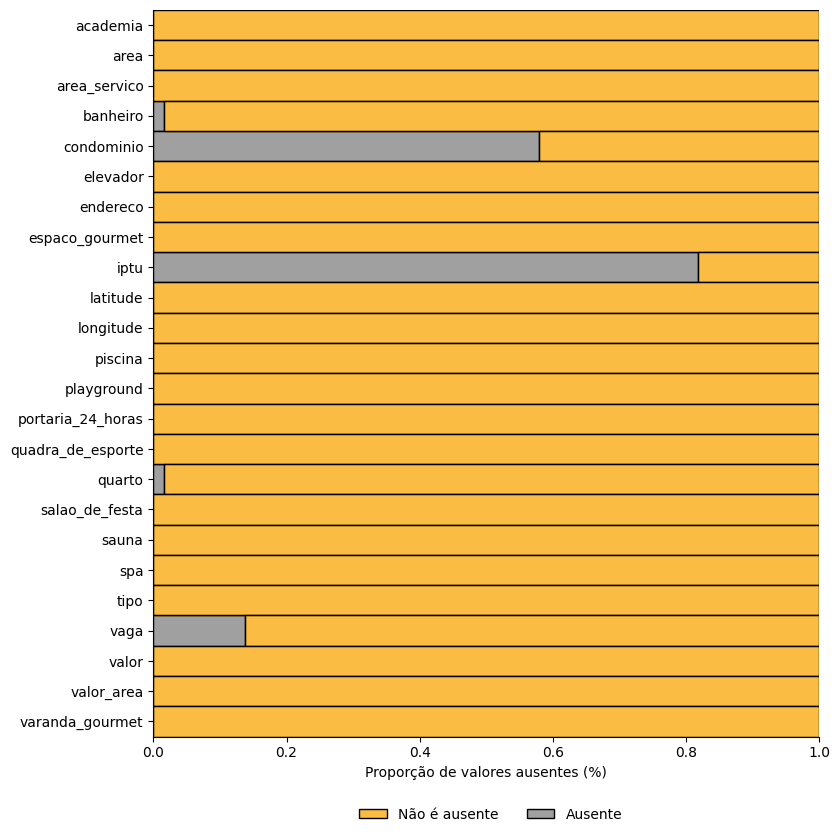

In [161]:
g_missing = sns.displot(
    data=df.isnull() \
        .melt(value_name='Valores ausentes') \
        .replace([False, True], ["Não é ausente", "Ausente"]) \
        .groupby(["variable", "Valores ausentes"]).size() \
        .reset_index(name="count") \
        .assign(
            proportion=lambda x: x.groupby("variable")["count"].transform(lambda y: y / y.sum())
        ),
    y='variable',
    hue='Valores ausentes',
    weights="proportion",
    multiple='fill',
    height=8,
    aspect=1.1,
    palette={"Não é ausente": "#f9a602", "Ausente": "gray"}
    )

sns.move_legend(obj=g_missing, loc="upper center",
                bbox_to_anchor=(.5, -.0001), ncol=2, title="")
g_missing.set(xlabel="Proporção de valores ausentes (%)", ylabel="")